## Cats dataset
The CAT dataset includes over 9,000 cat images. For each image, there are annotations of the head of cat with nine points, two for eyes, one for mouth, and six for ears.

In [1]:
import zipfile
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
from fastai.vision.all import *

In [33]:
with zipfile.ZipFile('/storage/archive/cats_face.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

In [2]:
path = pathlib.Path('/storage/archive/cats_face/')
list(path.glob('*'))

[Path('/storage/archive/cats_face/CAT_05'),
 Path('/storage/archive/cats_face/CAT_00'),
 Path('/storage/archive/cats_face/CAT_04'),
 Path('/storage/archive/cats_face/CAT_02'),
 Path('/storage/archive/cats_face/CAT_01'),
 Path('/storage/archive/cats_face/CAT_06'),
 Path('/storage/archive/cats_face/CAT_03')]

In [3]:
list(path.joinpath('CAT_00').glob('*'))[0:6]

[Path('/storage/archive/cats_face/CAT_00/00000073_000.jpg.cat'),
 Path('/storage/archive/cats_face/CAT_00/00000367_004.jpg'),
 Path('/storage/archive/cats_face/CAT_00/00000431_009.jpg.cat'),
 Path('/storage/archive/cats_face/CAT_00/00000011_001.jpg'),
 Path('/storage/archive/cats_face/CAT_00/00000430_024.jpg.cat'),
 Path('/storage/archive/cats_face/CAT_00/00000099_008.jpg')]

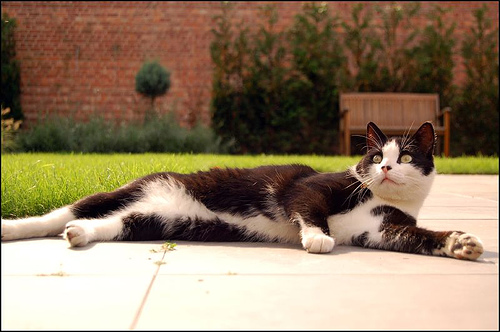

In [4]:
sample_image = '/storage/archive/cats_face/CAT_00/00000099_008.jpg'
image = Image.open(sample_image)
image

## The Annotation
1. Number of points (default is 9)
2. Left Eye
3. Right Eye
4. Mouth
5. Left Ear-1
6. Left Ear-2
7. Left Ear-3
8. Right Ear-1
9. Right Ear-2
10. Right Ear-3

In [5]:
def get_key_points_from_image_name(image_name):
    image_name = str(image_name)
    with open(image_name + '.cat') as x:
        key_point = x.read().split()[1:]
        key_point = list(map(float, key_point))
    return tensor(key_point)
key_point = get_key_points_from_image_name(sample_image)
key_point

tensor([377., 159., 406., 159., 385., 173., 368., 150., 370., 121., 387., 137.,
        409., 137., 427., 120., 431., 151.])

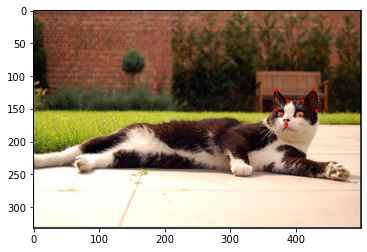

In [6]:
plt.imshow(image)
x_coor = [int(n) for i,n in enumerate(key_point) if i % 2 == 0]
y_coor = [int(n) for i,n in enumerate(key_point) if i % 2 != 0]
plt.scatter(x_coor,y_coor,s=20, marker='.', c='r')

**In this task I focus finding only the mouth coordinate**

In [7]:
def get_Mouth_key_points_from_image_name(image_name):
    image_name = str(image_name)
    with open(image_name + '.cat') as x:
        key_point = x.read().split()[5:7]
        key_point = list(map(float, key_point))
    return tensor(key_point)
key_point = get_Mouth_key_points_from_image_name(sample_image)
key_point

tensor([385., 173.])

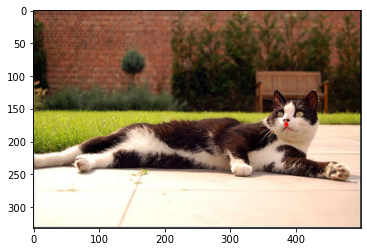

In [8]:
plt.imshow(image)
x_coor = [int(n) for i,n in enumerate(key_point) if i % 2 == 0]
y_coor = [int(n) for i,n in enumerate(key_point) if i % 2 != 0]
plt.scatter(x_coor,y_coor,s=30, marker='.', c='r')

In [9]:
# clean image with Mouth coordinates outside the image (negative number)

for f in get_image_files(path):
    key_points = get_Mouth_key_points_from_image_name(f)
    if ((key_points < 0).sum()) > 0:
        f_name = f.parts[-1]
        f.rename(f"/storage/archive/cats_face_with_minus/{f_name}")
        
(get_image_files(path))

(#9997) [Path('/storage/archive/cats_face/CAT_05/00001168_006.jpg'),Path('/storage/archive/cats_face/CAT_05/00001138_024.jpg'),Path('/storage/archive/cats_face/CAT_05/00001150_013.jpg'),Path('/storage/archive/cats_face/CAT_05/00001265_007.jpg'),Path('/storage/archive/cats_face/CAT_05/00001220_004.jpg'),Path('/storage/archive/cats_face/CAT_05/00001260_007.jpg'),Path('/storage/archive/cats_face/CAT_05/00001280_015.jpg'),Path('/storage/archive/cats_face/CAT_05/00001100_023.jpg'),Path('/storage/archive/cats_face/CAT_05/00001273_015.jpg'),Path('/storage/archive/cats_face/CAT_05/00001242_004.jpg')...]

## Data Block
- X: is an image
- Y: is a point
- tfms: resize to 256x256, nromalize, and augmentation.

In [10]:
dblock = DataBlock(blocks=(ImageBlock, PointBlock),
                   get_items=get_image_files,
                   get_y = get_Mouth_key_points_from_image_name,
                   splitter=RandomSplitter(),
                   item_tfms = Resize(360, ResizeMethod.Squish),
                   batch_tfms=[*aug_transforms(size=(256,256)),
                               Normalize.from_stats(*imagenet_stats)]
)

dls = dblock.dataloaders(path)

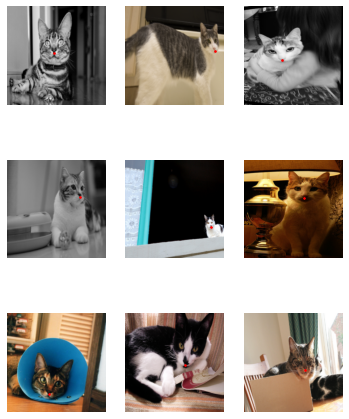

In [11]:
# show batch
dls.show_batch(max_n=9, figsize=(6,8))

In [12]:
# show batch size
xb,yb = dls.one_batch()
xb.shape,yb.shape, yb[0:5]

(torch.Size([64, 3, 256, 256]),
 torch.Size([64, 1, 2]),
 TensorPoint([[[-0.0579, -0.1125]],
 
         [[-0.0299,  0.0712]],
 
         [[-0.1937, -0.0413]],
 
         [[-0.5842,  0.3639]],
 
         [[ 0.6691, -0.0335]]], device='cuda:0'))

## Learning
- transfer learning using pre-trained resnet34
- optim- Adam
- loss function- MSELoss
- 3 epochs update only the head 
- 7 epochs update all model
- learning rate use the difault parametrs which are: 
    - base lr = 0.002
    - use fit_one_cycle- start with low lr increase during learning and lower toward the end
    - use slice lr - hige lr for the finals layers and low for the starts layer

In [13]:
learn = cnn_learner(dls, resnet34, y_range=(-1,1))
learn.loss_func, learn.opt_func

(FlattenedLoss of MSELoss(),
 <function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>)

In [14]:
learn.fine_tune(7, freeze_epochs=3)

epoch,train_loss,valid_loss,time
0,0.390958,0.182593,02:02
1,0.266872,0.108254,01:55
2,0.108607,0.053600,01:57


epoch,train_loss,valid_loss,time
0,0.035175,0.013541,02:23
1,0.012931,0.005859,02:21
2,0.008067,0.004088,02:25
3,0.005844,0.002857,02:24
4,0.004919,0.002675,02:22
5,0.003898,0.002258,02:22
6,0.003624,0.002099,02:22


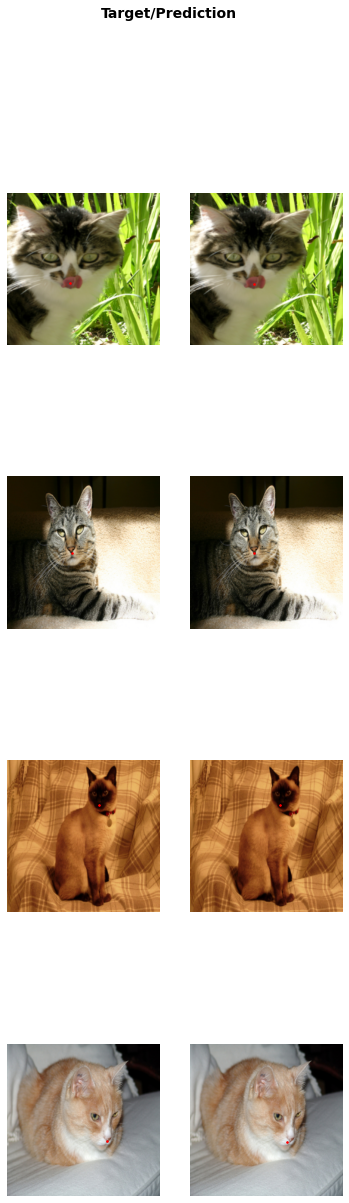

In [15]:
learn.show_results(ds_idx=1, nrows=4, figsize=(6,20))

## The MODEL FINDS THE CAT'S MOUTH!! ## 